# Starting kit for the Higgs boson machine learning challenge

This notebook contains a starting kit for the <a href="https://www.kaggle.com/c/higgs-boson">
Higgs boson machine learning challenge</a>. Download the training set (called <code>training.csv</code>) and the test set (<code>test.csv</code>), then execute cells in order.

In [1]:
import random,string,math,csv
import numpy as np
import matplotlib.pyplot as plt

## Reading an formatting training data

In [2]:
#all = list(csv.reader(open("training.csv","rb"), delimiter=','))
all = list(csv.reader(open("training.csv","r"), delimiter=','))
#all



Slicing off header row and id, weight, and label columns.

In [3]:
#xs = np.array([map(float, row[1:-2]) for row in all[1:]])
#(numPoints,numFeatures) = xs.shape

print(len(all))
print(len(all[0]))

250001
33


In [4]:
xs = np.array(all)[1:,1:(33-2)].astype(float)

In [5]:
(numPoints,numFeatures) = xs.shape

Perturbing features to avoid ties. It's far from optimal but makes life easier in this simple example.

In [6]:
xs = np.add(xs, np.random.normal(0.0, 0.0001, xs.shape))

#print(np.random.normal(0.0, 0.0001, xs.shape))
#print(xs)

Label selectors.

In [7]:
sSelector = np.array([row[-1] == 's' for row in all[1:]])
bSelector = np.array([row[-1] == 'b' for row in all[1:]])

Weights and weight sums.

In [8]:
weights = np.array([float(row[-2]) for row in all[1:]])
sumWeights = np.sum(weights)
sumSWeights = np.sum(weights[sSelector])
sumBWeights = np.sum(weights[bSelector])

## Training and validation cuts

We will train a classifier on a random training set for minimizing the weighted error with balanced weights, then we will maximize the AMS on the held out validation set.

In [9]:
randomPermutation = random.sample(range(len(xs)), len(xs))
numPointsTrain = int(numPoints*0.9)
numPointsValidation = numPoints - numPointsTrain

xsTrain = xs[randomPermutation[:numPointsTrain]]
xsValidation = xs[randomPermutation[numPointsTrain:]]

sSelectorTrain = sSelector[randomPermutation[:numPointsTrain]]
bSelectorTrain = bSelector[randomPermutation[:numPointsTrain]]
sSelectorValidation = sSelector[randomPermutation[numPointsTrain:]]
bSelectorValidation = bSelector[randomPermutation[numPointsTrain:]]

weightsTrain = weights[randomPermutation[:numPointsTrain]]
weightsValidation = weights[randomPermutation[numPointsTrain:]]

sumWeightsTrain = np.sum(weightsTrain)
sumSWeightsTrain = np.sum(weightsTrain[sSelectorTrain])
sumBWeightsTrain = np.sum(weightsTrain[bSelectorTrain])

In [10]:
xsTrainTranspose = xsTrain.transpose()

Making signal and background weights sum to $1/2$ each to emulate uniform priors $p(s)=p(b)=1/2$.

In [11]:
weightsBalancedTrain = np.array([0.5 * weightsTrain[i]/sumSWeightsTrain
                                 if sSelectorTrain[i]
                                 else 0.5 * weightsTrain[i]/sumBWeightsTrain\
                                 for i in range(numPointsTrain)])

## Training naive Bayes and defining the score function

Number of bins per dimension for binned naive Bayes.

In [12]:
numBins = 10

<code>logPs[fI,bI]</code> will be the log probability of a data point <code>x</code> with <code>binMaxs[bI - 1] < x[fI] <= binMaxs[bI]</code> (with <code>binMaxs[-1] = -</code>$\infty$ by convention) being a signal under uniform priors $p(\text{s}) = p(\text{b}) = 1/2$.

In [13]:
logPs = np.empty([numFeatures, numBins])
binMaxs = np.empty([numFeatures, numBins])
binIndexes = np.array(range(0, numPointsTrain+1, numPointsTrain//numBins))


In [14]:
for fI in range(numFeatures):
    # index permutation of sorted feature column
    indexes = xsTrainTranspose[fI].argsort()

    for bI in range(numBins):
        # upper bin limits
        binMaxs[fI, bI] = xsTrainTranspose[fI, indexes[binIndexes[bI+1]-1]]
        # training indices of points in a bin
        indexesInBin = indexes[binIndexes[bI]:binIndexes[bI+1]]
        # sum of signal weights in bin
        wS = np.sum(weightsBalancedTrain[indexesInBin]
                    [sSelectorTrain[indexesInBin]])
        # sum of background weights in bin
        wB = np.sum(weightsBalancedTrain[indexesInBin]
                    [bSelectorTrain[indexesInBin]])
        # log probability of being a signal in the bin
        logPs[fI, bI] = math.log(wS/(wS+wB))

The score function we will use to sort the test examples. For readability it is shifted so negative means likely background (under uniform prior) and positive means likely signal. <code>x</code> is an input vector.

In [15]:
def score(x):
    logP = 0
    for fI in range(numFeatures):
        bI = 0
        # linear search for the bin index of the fIth feature
        # of the signal
        while bI < len(binMaxs[fI]) - 1 and x[fI] > binMaxs[fI, bI]:
            bI += 1
        logP += logPs[fI, bI] - math.log(0.5)
    return logP

## Optimizing the AMS on the held out validation set

The Approximate Median Significance
\begin{equation*}
\text{AMS} = \sqrt{ 2 \left( (s + b + 10) \ln \left( 1 + \frac{s}{b +
    10} \right) - s \right) }
\end{equation*}
<code>s</code> and <code>b</code> are the sum of signal and background weights, respectively, in the selection region.

In [16]:
def AMS(s,b):
    assert s >= 0
    assert b >= 0
    bReg = 10.
    return math.sqrt(2 * ((s + b + bReg) * 
                          math.log(1 + s / (b + bReg)) - s))

Computing the scores on the validation set

In [17]:
validationScores = np.array([score(x) for x in xsValidation])

Sorting the indices in increasing order of the scores.

In [18]:
tIIs = validationScores.argsort()

Weights have to be normalized to the same sum as in the full set.

In [19]:
wFactor = 1.* numPoints / numPointsValidation

Initializing $s$ and $b$ to the full sum of weights, we start by having all points in the selectiom region.

In [20]:
s = np.sum(weightsValidation[sSelectorValidation])
b = np.sum(weightsValidation[bSelectorValidation])

<code>amss</code> will contain AMSs after each point moved out of the selection region in the sorted validation set.

In [21]:
amss = np.empty([len(tIIs)])

<code>amsMax</code> will contain the best validation AMS, and <code>threshold</code> will be the smallest score among the selected points.

In [22]:
amsMax = 0
threshold = 0.0

We will do <code>len(tIIs)</code> iterations, which means that <code>amss[-1]</code> is the AMS when only the point with the highest score is selected.

In [23]:
for tI in range(len(tIIs)):
    # don't forget to renormalize the weights to the same sum 
    # as in the complete training set
    amss[tI] = AMS(max(0,s * wFactor),max(0,b * wFactor))
    if amss[tI] > amsMax:
        amsMax = amss[tI]
        threshold = validationScores[tIIs[tI]]
        #print tI,threshold
    if sSelectorValidation[tIIs[tI]]:
        s -= weightsValidation[tIIs[tI]]
    else:
        b -= weightsValidation[tIIs[tI]]

In [24]:
amsMax

2.049448232665019

In [25]:
threshold

-0.08554924176178968

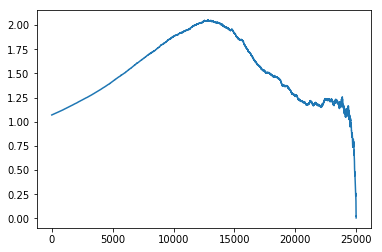

In [26]:
plt.plot(amss)

## Computing the permutation on the test set

Reading the test file, slicing off the header row and the id column, and converting the data into float.

In [27]:
test = list(csv.reader(open("test.csv","r"), delimiter=','))

In [28]:
xsTest = np.array(test)[1:,1:].astype(float)

In [29]:
xsTest[0,:]

array([-9.9900e+02,  7.9589e+01,  2.3916e+01,  3.0360e+00, -9.9900e+02,
       -9.9900e+02, -9.9900e+02,  9.0300e-01,  3.0360e+00,  5.6018e+01,
        1.5360e+00, -1.4040e+00, -9.9900e+02,  2.2088e+01, -5.4000e-01,
       -6.0900e-01,  3.3930e+01, -5.0400e-01, -1.5110e+00,  4.8509e+01,
        2.0220e+00,  9.8556e+01,  0.0000e+00, -9.9900e+02, -9.9900e+02,
       -9.9900e+02, -9.9900e+02, -9.9900e+02, -9.9900e+02, -0.0000e+00])

In [30]:
testIds = np.array([int(row[0]) for row in test[1:]])

In [31]:
testIds

array([350000, 350001, 350002, ..., 899997, 899998, 899999])

#Computing the scores.

In [32]:
#testScores = np.array(score(x) for x in xsTest)
testScores = []


for i in range(len(xsTest)):
    testScores.append(score(xsTest[i]))

Computing the rank order.

In [33]:
testInversePermutation = np.array(testScores).argsort()

testInversePermutation

array([451308,  79647, 273074, ..., 519731, 113763, 146583], dtype=int64)

In [34]:
testPermutation = list(testInversePermutation)
for tI,tII in zip(range(len(testInversePermutation)),
                  testInversePermutation):
    testPermutation[tII] = tI

Computing the submission file with columns EventId, RankOrder, and Class.

In [35]:
#submission = np.array([str(testIds[tI]),str(testPermutation[tI]+1),
                       #'s' if testScores[tI] >= threshold else 'b'] for tI in range(len(testIds)))
submission = [];
for tI in range(len(testIds)):
    if testScores[tI] >= threshold:
        submission.append([str(testIds[tI]),str(testPermutation[tI]+1),'s'])
    else: 
        submission.append([str(testIds[tI]),str(testPermutation[tI]+1),'b'])
submission = np.array(submission)

In [36]:
submission = np.append([['EventId','RankOrder','Class']], submission, axis=0)

Saving the file that can be submitted to Kaggle.

In [37]:
np.savetxt("./submission.csv",submission,fmt='%s',delimiter=',')